<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 4
%autosave 120

Autosaving every 120 seconds


In [2]:
from fastai.io import *
from fastai.structured import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from pandas_summary import DataFrameSummary
from IPython.display import display
from sklearn import metrics
import feather
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error
import warnings

In [23]:
import gc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import time
import matplotlib.gridspec as gridspec
import seaborn as sns
gc.enable()

In [49]:
gc.collect()

0

In [5]:
data = feather.read_dataframe('train_df_beta')

In [18]:
for df in [data]:
    for f in ['purchase_date_max','purchase_date_min','purchase_date_max_old',\
                     'purchase_date_min_old']:
        df[f] = df[f].astype(np.int64) * 1e-9

In [6]:
categorical_feats = [
    f for f in data.columns if data[f].dtype == 'object'
]


In [11]:
categorical_feats = ['feature_1', 'feature_2', 'feature_3']

In [12]:
DataFrameSummary(data).summary().

,first_active_month,card_id,feature_1,feature_2,feature_3,target,first_active_monthYear,first_active_monthMonth,first_active_monthWeek,first_active_monthDay,...,days_feature3,days_feature1_ratio,days_feature2_ratio,days_feature3_ratio,feature_sum,feature_prod,feature_mean,feature_max,feature_min,feature_var
count,NaN,NaN,201917,201917,201917,201917,201917,201917,201917,201917,...,201917,201917,201917,201917,201917,201917,201917,201917,201917,201917
mean,NaN,NaN,0.0109302,0.0109302,0.0109302,-0.393636,2016.51,7.37874,30.9446,1,...,456.1,0.00453651,0.00254031,0.000802191,5.41629,3.59235,1.80543,3.17985,0.565569,1.41657
std,NaN,NaN,0.0012591,0.00195247,0.000567402,3.8505,0.788199,3.34072,13.8454,0,...,473.06,0.00217687,0.0013285,0.000787088,1.64767,3.66582,0.549224,1.1209,0.495683,0.514542
min,NaN,NaN,0.00805849,0.00875212,0.0102828,-33.2193,2011,1,1,1,...,0,0.000666223,0.000376223,0,2,0,0.666667,1,0,0.57735
25%,NaN,NaN,0.0104794,0.00875212,0.0102828,-0.88311,2016,5,22,1,...,0,0.00294118,0.00162866,0,4,0,1.33333,2,0,1
50%,NaN,NaN,0.0106099,0.0113848,0.0114275,-0.0234369,2017,8,31,1,...,497,0.00405954,0.00214592,0.000814332,5,3,1.66667,3,1,1.1547
75%,NaN,NaN,0.0107116,0.0113848,0.0114275,0.765453,2017,10,44,1,...,770,0.00588235,0.00323102,0.00147059,7,6,2.33333,4,1,2.08167
max,NaN,NaN,0.0131446,0.0141664,0.0114275,17.9651,2018,12,53,1,...,2658,0.0123457,0.00740741,0.00246914,8,10,2.66667,5,1,2.3094
counts,201917,201917,201917,201917,201917,201917,201917,201917,201917,201917,...,201917,201917,201917,201917,201917,201917,201917,201917,201917,201917
uniques,75,201917,5,3,2,197110,8,12,21,1,...,75,239,189,75,7,6,7,5,2,9


In [67]:
def get_feature_importances(data, shuffle, seed=None):
    # Gather real features
    train_features = [f for f in data if f not in ['card_id', 'first_active_month','target','outliers']]
    # Go over fold and keep track of CV score (train and valid) and feature importances
    
    # Shuffle target if required
    y = data['target'].copy()
    if shuffle:
        # Here you could as well use a binomial distribution
        y = data['target'].copy().sample(frac=1.0)
    
    # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    dtrain = lgb.Dataset(data[train_features], y, free_raw_data=False, silent=True)
    lgb_params = {
        'objective': 'regression',
        'boosting_type': 'rf',
        'subsample': 0.623,
        'colsample_bytree': 0.7,
        'num_leaves': 123,
        'max_depth': 8,
        'seed': seed,
        'bagging_freq': 1,
        'n_jobs': 4
    }
    
    # Fit the model
    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200)

    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(train_features)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    imp_df['trn_score'] = np.sqrt(mean_squared_error(y, clf.predict(data[train_features])))
    return imp_df

In [68]:
# Seed the unexpected randomness of this world
np.random.seed(123)
# Get the actual importance, i.e. without shuffling
actual_imp_df = get_feature_importances(data=data, shuffle=False)

In [69]:
actual_imp_df.head()

,feature,importance_gain,importance_split,trn_score
0,feature_1,9002.868225,6,3.573472
1,feature_2,8478.942017,6,3.573472
2,feature_3,1668.579956,1,3.573472
3,first_active_monthYear,6028.738983,6,3.573472
4,first_active_monthMonth,34846.068115,25,3.573472


In [70]:
null_imp_df = pd.DataFrame()
nb_runs = 200
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(data=data, shuffle=True)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)

Done with  200 of  200 (Spent  51.8 min)

In [71]:
null_imp_df.head()

,feature,importance_gain,importance_split,trn_score,run
0,feature_1,952.168175,4,3.829012,1
1,feature_2,1620.626999,4,3.829012,1
2,feature_3,339.544006,1,3.829012,1
3,first_active_monthYear,522.403015,1,3.829012,1
4,first_active_monthMonth,3847.946195,19,3.829012,1


In [72]:
def display_distributions(actual_imp_df_, null_imp_df_, feature_):
    plt.figure(figsize=(13, 6))
    gs = gridspec.GridSpec(1, 2)
    # Plot Split importances
    ax = plt.subplot(gs[0, 0])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_split'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_split'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Split Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (split) Distribution for %s ' % feature_.upper())
    # Plot Gain importances
    ax = plt.subplot(gs[0, 1])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_gain'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_gain'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Gain Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (gain) Distribution for %s ' % feature_.upper())

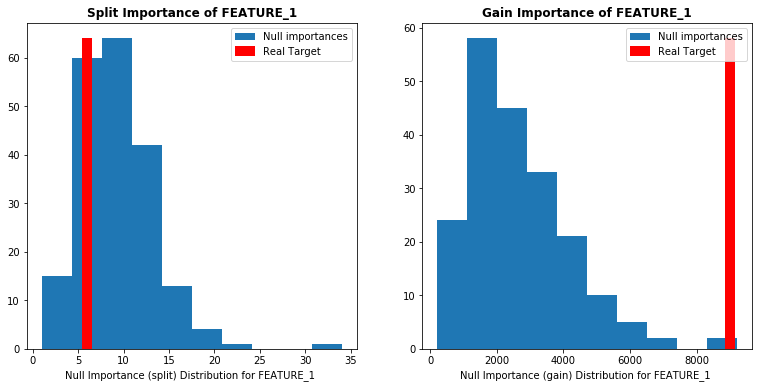

In [74]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='feature_1')

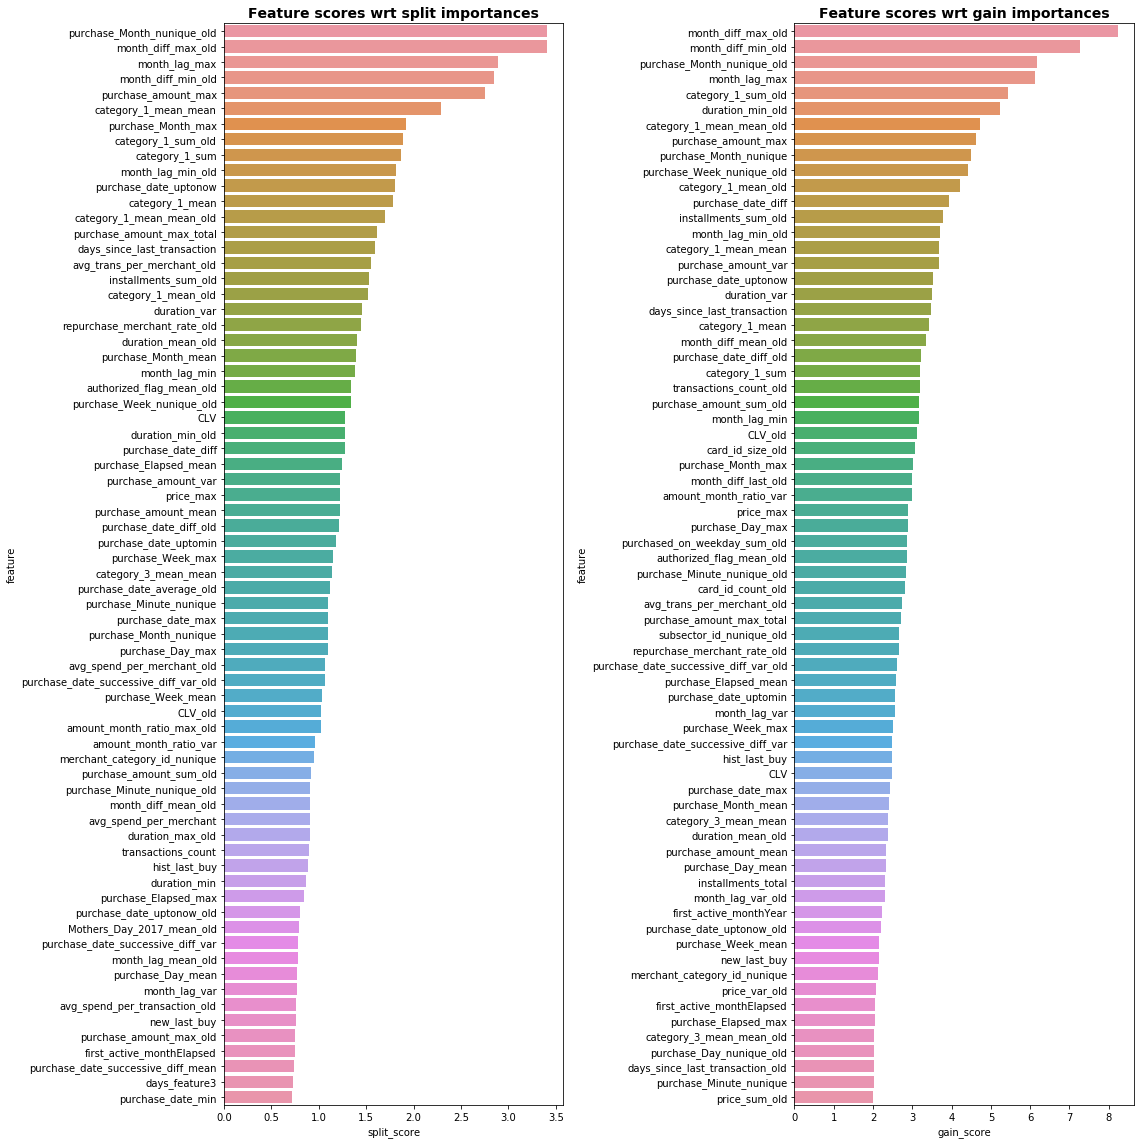

In [75]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()

In [73]:
null_imp_df.to_csv('null_importances_distribution_rf.csv')
actual_imp_df.to_csv('actual_importances_ditribution_rf.csv')

In [76]:
null_imp_df.head()

,feature,importance_gain,importance_split,trn_score,run
0,feature_1,952.168175,4,3.829012,1
1,feature_2,1620.626999,4,3.829012,1
2,feature_3,339.544006,1,3.829012,1
3,first_active_monthYear,522.403015,1,3.829012,1
4,first_active_monthMonth,3847.946195,19,3.829012,1


In [77]:
actual_imp_df.head()

,feature,importance_gain,importance_split,trn_score
0,feature_1,9002.868225,6,3.573472
1,feature_2,8478.942017,6,3.573472
2,feature_3,1668.579956,1,3.573472
3,first_active_monthYear,6028.738983,6,3.573472
4,first_active_monthMonth,34846.068115,25,3.573472


In [79]:
null_imp_df.sort_values('importance_gain').head(30)

,feature,importance_gain,importance_split,trn_score,run
186,month_diff_min_old,0.0,0,3.826713,117
268,quarter,0.0,0,3.827946,150
260,purchased_before_issue,0.0,0,3.827946,150
227,purchase_date_successive_diff_min_old,0.0,0,3.827946,150
203,card_id_count_old,0.0,0,3.827946,150
22,purchase_Month_nunique,0.0,0,3.828426,105
11,first_active_monthIs_quarter_end,0.0,0,3.827523,87
10,first_active_monthIs_month_start,0.0,0,3.827523,87
112,purchase_date_successive_diff_min,0.0,0,3.827946,150
186,month_diff_min_old,0.0,0,3.828946,62


In [80]:
actual_imp_df.sort_values('importance_gain').head(30)

,feature,importance_gain,importance_split,trn_score
10,first_active_monthIs_month_start,0.000000,0,3.573472
78,authorized_flag_mean,0.000000,0,3.573472
90,Mothers_Day_2017_mean,0.000000,0,3.573472
279,feature_min,0.000000,0,3.573472
14,first_active_monthIs_year_start,0.000000,0,3.573472
268,quarter,0.000000,0,3.573472
6,first_active_monthDay,0.000000,0,3.573472
260,purchased_before_issue,0.000000,0,3.573472
227,purchase_date_successive_diff_min_old,0.000000,0,3.573472
9,first_active_monthIs_month_end,0.000000,0,3.573472


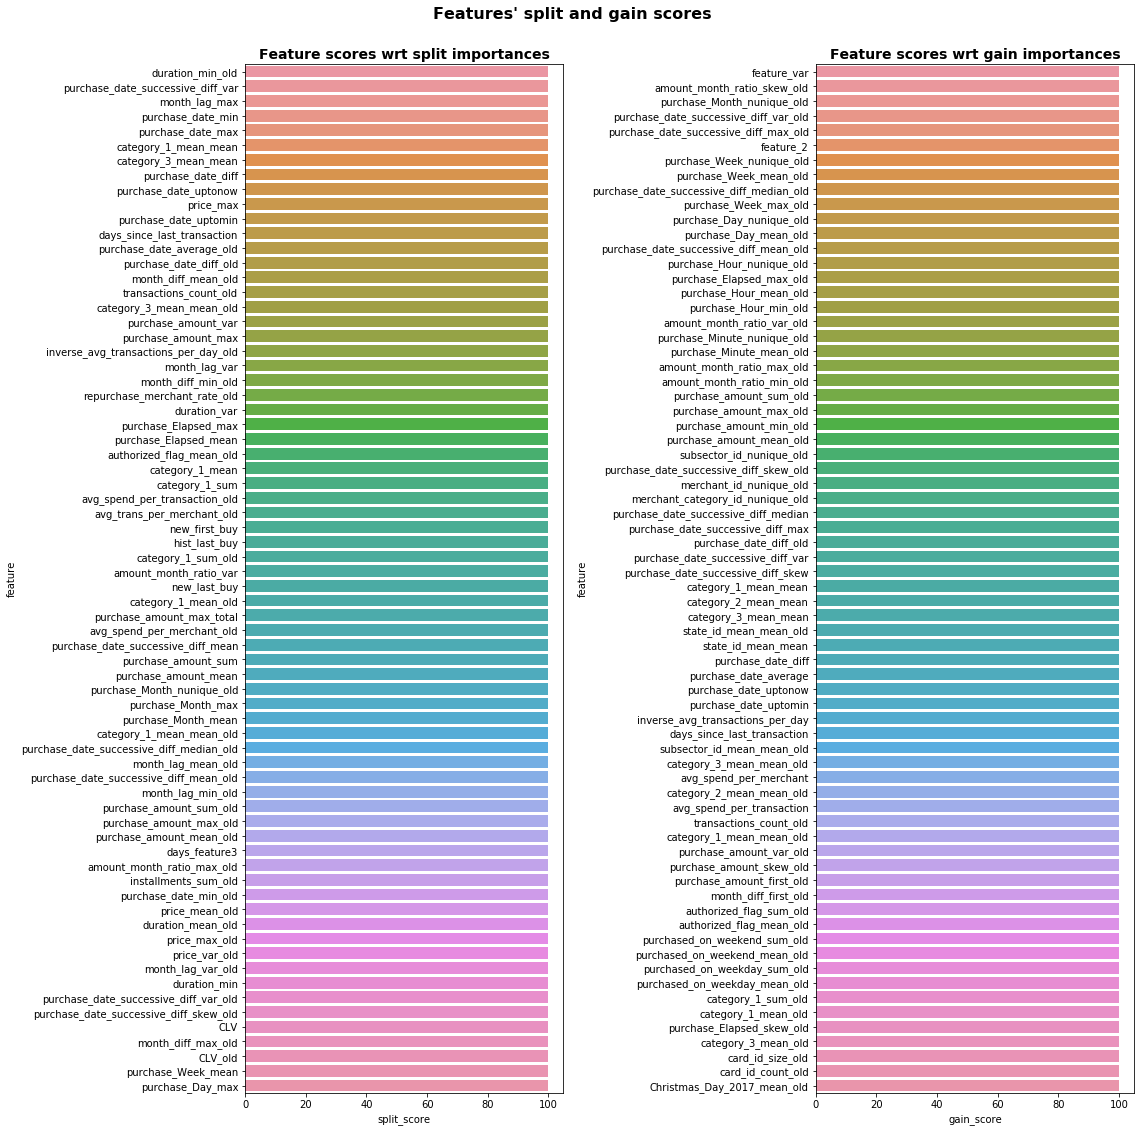

In [81]:
correlation_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].values
    gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].values
    split_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    correlation_scores.append((_f, split_score, gain_score))

corr_scores_df = pd.DataFrame(correlation_scores, columns=['feature', 'split_score', 'gain_score'])

fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=corr_scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=corr_scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.suptitle("Features' split and gain scores", fontweight='bold', fontsize=16)
fig.subplots_adjust(top=0.93)

In [98]:
corr_scores_df.head()

,feature,split_score,gain_score
0,feature_1,17.0,99.5
1,feature_2,41.0,100.0
2,feature_3,17.5,94.0
3,first_active_monthYear,94.0,98.5
4,first_active_monthMonth,52.0,100.0


In [99]:
corr_scores_df.to_csv('corr_scores_null_importances.csv')

In [94]:
def score_feature_selection(df=None, train_features=None, cat_feats=None, target=None):
    # Fit LightGBM 
    dtrain = lgb.Dataset(df[train_features], target, free_raw_data=False, silent=True)
    
    lgb_params = {
        'boosting': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.01,
        'subsample': 0.9855232997390695,
        'max_depth': 7,
        'top_rate': 0.9064148448434349,
        'num_leaves': 123,
        'min_child_weight': 41.9612869171337,
        'other_rate': 0.0721768246018207,
        'reg_alpha': 9.677537745007898,
        'colsample_bytree': 0.5665320670155495,
        'min_split_gain': 9.820197773625843,
        'reg_lambda': 8.2532317400459,
        'min_data_in_leaf': 21,
        'verbose': -1,
        'seed':4590,
        'bagging_seed':11,
        'drop_seed':11,
        'metric': 'rmse'
    }
    
    # Fit the model
    hist = lgb.cv(
        params=lgb_params, 
        train_set=dtrain, 
        num_boost_round=2000,
        nfold=5,
        stratified=False,
        shuffle=True,
        early_stopping_rounds=50,
        verbose_eval=0
    )
    # Return the last mean / std values 
    return hist['rmse-mean'][-1], hist['rmse-stdv'][-1]

In [97]:
for threshold in [0, 10, 20, 30 , 40, 50 ,60 , 70, 80 , 90, 95, 99]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
                                                                                             
    print('Results for threshold %3d' % threshold)
    split_results = score_feature_selection(df=data, train_features=split_feats, target=data['target'])
    print('\t SPLIT : %.6f +/- %.6f' % (split_results[0], split_results[1]))
    print('\t split_feats ::', len(split_feats))
    gain_results = score_feature_selection(df=data, train_features=gain_feats, target=data['target'])
    print('\t GAIN  : %.6f +/- %.6f' % (gain_results[0], gain_results[1]))
    print('\t gain_feats ::', len(gain_feats))

Results for threshold   0
	 SPLIT : 3.655472 +/- 0.027157
	 split_feats :: 281
	 GAIN  : 3.655472 +/- 0.027157
	 gain_feats :: 281
Results for threshold  10
	 SPLIT : 3.655812 +/- 0.024893
	 split_feats :: 232
	 GAIN  : 3.655556 +/- 0.026241
	 gain_feats :: 264
Results for threshold  20
	 SPLIT : 3.654744 +/- 0.025816
	 split_feats :: 219
	 GAIN  : 3.656210 +/- 0.027202
	 gain_feats :: 263
Results for threshold  30
	 SPLIT : 3.655640 +/- 0.026266
	 split_feats :: 208
	 GAIN  : 3.655798 +/- 0.026482
	 gain_feats :: 261
Results for threshold  40
	 SPLIT : 3.655650 +/- 0.025402
	 split_feats :: 196
	 GAIN  : 3.655698 +/- 0.026479
	 gain_feats :: 260
Results for threshold  50
	 SPLIT : 3.655803 +/- 0.025446
	 split_feats :: 189
	 GAIN  : 3.655336 +/- 0.026007
	 gain_feats :: 259
Results for threshold  60
	 SPLIT : 3.654736 +/- 0.024136
	 split_feats :: 174
	 GAIN  : 3.655336 +/- 0.026007
	 gain_feats :: 259
Results for threshold  70
	 SPLIT : 3.654500 +/- 0.024940
	 split_feats :: 168
	 GA

In [101]:
train_missing = (data.isnull().sum() / len(data)).sort_values(ascending = False)
train_missing.head()

price_skew           0.680468
price_var            0.618710
price_skew_old       0.503727
price_var_old        0.503400
installments_skew    0.369285
dtype: float64

In [103]:
train_missing.head(50)

price_skew                            0.680468
price_var                             0.618710
price_skew_old                        0.503727
price_var_old                         0.503400
installments_skew                     0.369285
purchase_amount_skew                  0.355933
amount_month_ratio_skew               0.355933
month_diff_skew                       0.355933
purchase_date_successive_diff_skew    0.355933
duration_skew                         0.355933
month_lag_skew                        0.355933
purchase_Elapsed_skew                 0.355933
installments_ratio                    0.328194
installments_var                      0.252559
month_diff_var                        0.241277
purchase_date_successive_diff_var     0.241277
month_lag_var                         0.241277
purchase_amount_var                   0.241277
amount_month_ratio_var                0.241277
duration_var                          0.241277
price_mean_old                        0.177355
price_sum_old